# Relax Data Challenge

### Dependencies & data

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set()
%matplotlib inline

In [2]:
# Usage data
usage_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
print(usage_df.info())
usage_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


In [3]:
# User data
user_df = pd.read_csv('takehome_users.csv', parse_dates=['creation_time'], encoding='latin-1')
print(user_df.info())
user_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB
None


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [4]:
# Rename `object_id` to `user_id`
user_df.rename(columns={'object_id': 'user_id'}, inplace=True)

# Convert `last_session_creation_time` to datetime
user_df['last_session_creation_time'] = pd.to_datetime(user_df.last_session_creation_time, unit='s')
user_df.head(2)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0


### Label adopted users and count usage for each user

In [5]:
# Group visits by each user's weekly visits
weekly_usage_df = usage_df.groupby(['user_id', pd.Grouper(key='time_stamp', freq='7d')]).count()

# Filter for users who visited at least 3 times during any week
adopted_usage_df = weekly_usage_df[weekly_usage_df['visited'] >= 3]
adopted_users = adopted_usage_df.index.get_level_values(0).unique().values

print(len(adopted_users))
weekly_usage_df.head(2)

1445


,,visited
user_id,time_stamp,
1,2014-04-17,1
2,2013-11-14,1


In [6]:
# Create label for adopted users
user_df['adopted_user'] = np.where(user_df['user_id'].isin(adopted_users), 1, 0)
assert user_df['adopted_user'].sum() == len(adopted_users) # confirm equal length
user_df.head(2)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,0


In [7]:
# Create a feature for the number of times each user logged in
usage_count_df = usage_df.groupby('user_id', as_index=False).sum()
user_df = user_df.merge(usage_count_df, on='user_id', how='left')
user_df['visited'] = user_df['visited'].fillna(0).astype(int) # fill missing with 0
user_df.head(2)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,0,14


### Split data

In [8]:
# Split features and label
X = user_df.drop('adopted_user', axis=1)
y = user_df['adopted_user']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9000, 11), (3000, 11), (9000,), (3000,))

In [9]:
# Class (im)balance
y_train.value_counts()

0    7916
1    1084
Name: adopted_user, dtype: int64

### Resample data

In [10]:
# Split train data by label
train = X_train.merge(y_train, left_index=True, right_index=True)
train0 = train[train['adopted_user'] == 0]
train1 = train[train['adopted_user'] == 1]
train.shape, train0.shape, train1.shape

((9000, 12), (7916, 12), (1084, 12))

In [11]:
# Upsample positive labels
train1_resampled = train1.sample(train0.shape[0], replace=True, random_state=75)

# Combine training data
train_resampled = pd.concat([train0, train1_resampled]).reset_index(drop=True)
train_resampled['adopted_user'].value_counts()

0    7916
1    7916
Name: adopted_user, dtype: int64

In [12]:
# Split features and label
X_train_resampled = train_resampled.drop('adopted_user', axis=1).copy()
y_train_resampled = train_resampled['adopted_user'].copy()
X_train_resampled.shape, y_train_resampled.shape

((15832, 11), (15832,))

In [13]:
def join_label_into_feats(X, y):
    df = X.merge(y, left_index=True, right_index=True)
    return df

# Test function
join_label_into_feats(X_train_resampled, y_train_resampled).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15832 entries, 0 to 15831
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     15832 non-null  int64         
 1   creation_time               15832 non-null  datetime64[ns]
 2   name                        15832 non-null  object        
 3   email                       15832 non-null  object        
 4   creation_source             15832 non-null  object        
 5   last_session_creation_time  13435 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    15832 non-null  int64         
 7   enabled_for_marketing_drip  15832 non-null  int64         
 8   org_id                      15832 non-null  int64         
 9   invited_by_user_id          8692 non-null   float64       
 10  visited                     15832 non-null  int64         
 11  adopted_user                15832 non-null  int64     

### Datetime EDA

In [14]:
# Create a feature for each user's first day of use
first_use = dict(usage_df.groupby('user_id')['time_stamp'].min()) # save for test set
X_train_resampled['first_use'] = X_train_resampled['user_id'].map(first_use)

# Create a feature for the number of days between account creation and first use
X_train_resampled['days_to_first_use'] = (X_train_resampled['first_use'] - X_train_resampled['creation_time']).dt.days
X_train_resampled['days_to_first_use'].fillna(999, inplace=True)
X_train_resampled.head(2)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,first_use,days_to_first_use
0,11701,2012-12-03 11:33:34,Correia Pedro,cbbyrpyy@vlsfv.com,ORG_INVITE,NaT,0,0,173,3767.0,0,NaT,999.0
1,6407,2013-11-17 01:20:39,Foerster Sandra,SandraFoerster@gmail.com,ORG_INVITE,2013-11-18 01:20:39,1,1,154,8664.0,1,2013-11-18 01:20:39,1.0


In [15]:
# Days to first use
X_train_resampled['days_to_first_use'].value_counts()

0.0      6738
1.0      3403
999.0    2397
2.0      1751
3.0       750
4.0       366
5.0       233
6.0       116
7.0        44
8.0        13
10.0        9
9.0         8
12.0        2
14.0        1
11.0        1
Name: days_to_first_use, dtype: int64

In [16]:
# Create feature for same day use
X_train_resampled['same_day_use'] = (X_train_resampled['days_to_first_use'] == 0).astype(int)
X_train_resampled['same_day_use'].value_counts()

0    9094
1    6738
Name: same_day_use, dtype: int64

In [17]:
# Join label into features
train_resampled = join_label_into_feats(X_train_resampled, y_train_resampled)

# User adoption rate of users who login within the first n days
adoption_1d_df = train_resampled[train_resampled['days_to_first_use'] < 1]['adopted_user']
adoption_7d_df = train_resampled[train_resampled['days_to_first_use'] < 7]['adopted_user']
adoption_30d_df = train_resampled[train_resampled['days_to_first_use'] < 30]['adopted_user']

print(f'{adoption_1d_df.mean() * 100:.2f}% of users who login within the same DAY as creating an account are adopted users.')
print(f'{adoption_7d_df.mean() * 100:.2f}% of users who login within the same WEEK as creating an account are adopted users.')
print(f'{adoption_30d_df.mean() * 100:.2f}% of users who login within the same MONTH as creating an account are adopted users.')

60.09% of users who login within the same DAY as creating an account are adopted users.
58.98% of users who login within the same WEEK as creating an account are adopted users.
58.92% of users who login within the same MONTH as creating an account are adopted users.


In [18]:
# Check adoption rate of each signup month
monthly_adoption_df = train_resampled.groupby(pd.Grouper(key='creation_time', freq='M'))[['adopted_user']].mean().reset_index()
monthly_adoption_df['creation_time'] = monthly_adoption_df['creation_time'].dt.strftime('%Y-%m')
monthly_adoption_df.columns = ['creation_month', 'adoption_rate']
monthly_adoption_df

,creation_month,adoption_rate
0,2012-05,0.523810
1,2012-06,0.575908
2,2012-07,0.563452
3,2012-08,0.596774
4,2012-09,0.572831
5,2012-10,0.526882
6,2012-11,0.569331
7,2012-12,0.565365
8,2013-01,0.474957
9,2013-02,0.600596


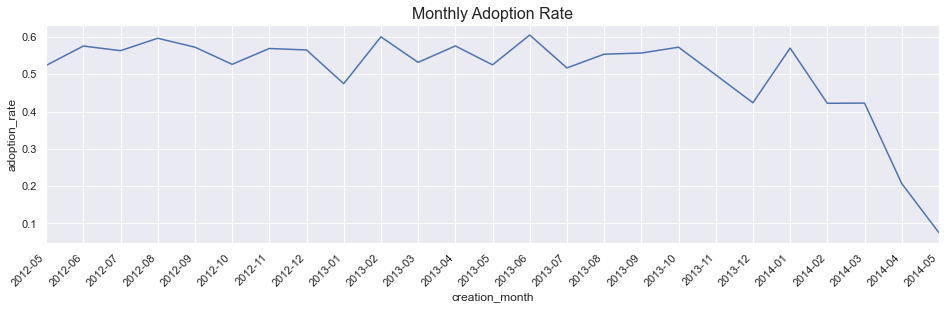

In [19]:
# Plot monthly adoption
plt.figure(figsize=(16, 4))
sns.lineplot(data=monthly_adoption_df, x='creation_month', y='adoption_rate')
plt.title('Monthly Adoption Rate', fontsize=16)
plt.xticks(ticks=range(monthly_adoption_df.shape[0]), labels=monthly_adoption_df['creation_month'], rotation=45, ha='right')
plt.xlim((0, monthly_adoption_df.shape[0] - 1));

### Categorical EDA

In [20]:
# Simplify `invited_by_user_id` to a boolean feature that indicates whether the user was invited
X_train_resampled['invited'] = (X_train_resampled['invited_by_user_id'].notnull()).astype(int)

# Extract email domain
X_train_resampled['email_domain'] = X_train_resampled['email'].str.split('@', expand=True)[1]

# Drop redundant columns
X_train_resampled.drop(['name', 'email', 'invited_by_user_id'], axis=1, inplace=True)
X_train_resampled.head(2)

,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,visited,first_use,days_to_first_use,same_day_use,invited,email_domain
0,11701,2012-12-03 11:33:34,ORG_INVITE,NaT,0,0,173,0,NaT,999.0,0,1,vlsfv.com
1,6407,2013-11-17 01:20:39,ORG_INVITE,2013-11-18 01:20:39,1,1,154,1,2013-11-18 01:20:39,1.0,0,1,gmail.com


In [21]:
# Inspect email domains
email_domains = X_train_resampled['email_domain'].value_counts(ascending=False)
email_domains[email_domains > 10]

gmail.com         4968
yahoo.com         2863
hotmail.com       1761
jourrapide.com    1718
gustr.com         1532
cuvox.de          1447
yhnuj.com           17
ofixp.com           14
tmbux.com           13
pcood.com           13
gixrq.com           12
ufnda.com           12
phocq.com           11
yglik.com           11
wqnsa.com           11
gobqd.com           11
ncvyi.com           11
hfbri.com           11
imknl.com           11
hsrfc.com           11
Name: email_domain, dtype: int64

In [22]:
# Group rare domains into a single category
common_domains = email_domains[email_domains > 20].index.values # save for test set
X_train_resampled['email_domain'] = X_train_resampled['email_domain'].apply(lambda d: d if d in common_domains else 'other')
X_train_resampled['email_domain'].value_counts()

gmail.com         4968
yahoo.com         2863
hotmail.com       1761
jourrapide.com    1718
other             1543
gustr.com         1532
cuvox.de          1447
Name: email_domain, dtype: int64

,adopted_user,visited
email_domain,,
cuvox.de,0.438839,56.359364
gmail.com,0.534219,76.544283
gustr.com,0.474543,65.406005
hotmail.com,0.596820,82.923907
jourrapide.com,0.504075,77.736321
other,0.490603,68.268957
yahoo.com,0.428222,50.894167


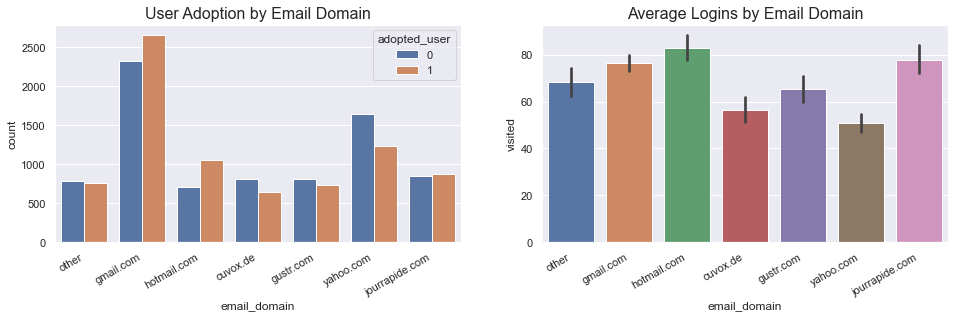

In [23]:
# Join label into features
train_resampled = join_label_into_feats(X_train_resampled, y_train_resampled)

# User adoption and average logins by email domain
fig1, ax1 = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train_resampled, x='email_domain', hue='adopted_user', ax=ax1[0])
sns.barplot(data=train_resampled, x='email_domain', y='visited', ax=ax1[1])
ax1[0].set_title('User Adoption by Email Domain', fontsize=16)
ax1[1].set_title('Average Logins by Email Domain', fontsize=16)
ax1[0].set_xticklabels(ax1[0].get_xticklabels(), rotation=30, ha='right')
ax1[1].set_xticklabels(ax1[1].get_xticklabels(), rotation=30, ha='right')

# User adoption rate and average logins by email domain
train_resampled.groupby('email_domain')[['adopted_user', 'visited']].mean()

,adopted_user,visited
creation_source,,
GUEST_INVITE,0.152566,21.634767
ORG_INVITE,0.115891,16.476493
PERSONAL_PROJECTS,0.067740,9.105637
SIGNUP,0.130810,17.989938
SIGNUP_GOOGLE_AUTH,0.148736,24.738628


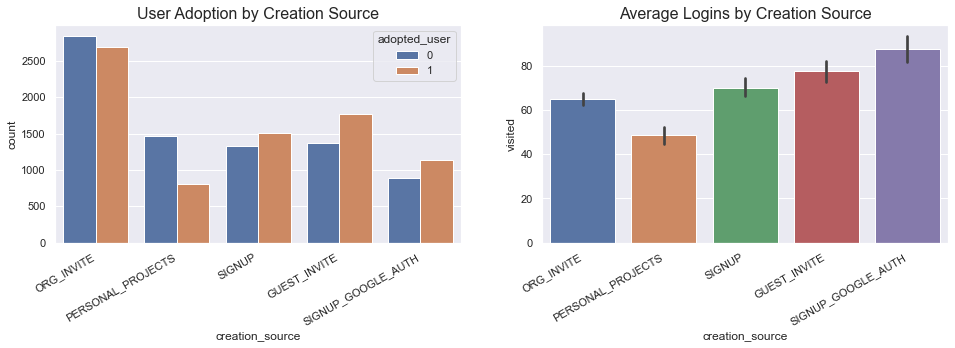

In [24]:
# User adoption and average logins by creation source
fig2, ax2 = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train_resampled, x='creation_source', hue='adopted_user', ax=ax2[0])
sns.barplot(data=train_resampled, x='creation_source', y='visited', ax=ax2[1])
ax2[0].set_title('User Adoption by Creation Source', fontsize=16)
ax2[1].set_title('Average Logins by Creation Source', fontsize=16)
ax2[0].set_xticklabels(ax2[0].get_xticklabels(), rotation=30, ha='right')
ax2[1].set_xticklabels(ax2[1].get_xticklabels(), rotation=30, ha='right')

# User adoption rate and average logins by creation source
user_df.groupby('creation_source')[['adopted_user', 'visited']].mean()

In [25]:
# Group organizations by size
org_users = X_train_resampled['org_id'].value_counts()
pd.qcut(org_users, 10)

0      (65.0, 268.0]
1      (65.0, 268.0]
2      (65.0, 268.0]
3      (65.0, 268.0]
4      (65.0, 268.0]
           ...      
386    (0.999, 14.0]
355    (0.999, 14.0]
410    (0.999, 14.0]
294    (0.999, 14.0]
416    (0.999, 14.0]
Name: org_id, Length: 417, dtype: category
Categories (10, interval[float64, right]): [(0.999, 14.0] < (14.0, 19.0] < (19.0, 23.0] < (23.0, 28.0] ... (35.0, 41.0] < (41.0, 48.0] < (48.0, 65.0] < (65.0, 268.0]]

In [26]:
# Group organizations into 9 bins depending on size
bin_size = 9
org_cats = pd.qcut(org_users, bin_size, labels=range(bin_size)).to_dict() # save for test set
X_train_resampled['org_size'] = X_train_resampled['org_id'].map(org_cats)

# Group categories 0 and 1
X_train_resampled['org_size'] = X_train_resampled['org_size'].apply(lambda i: 1 if i in [0, 1] else i)
X_train_resampled['org_size'].value_counts()

8    4649
7    2353
6    2051
4    1541
5    1502
1    1361
3    1250
2    1125
Name: org_size, dtype: int64

,adopted_user,visited
org_size,,
5,0.585220,87.629161
6,0.577279,76.802048
4,0.548345,76.978585
7,0.538037,84.080323
3,0.506400,58.248800
8,0.472145,59.667455
2,0.456889,74.510222
1,0.293902,38.957384


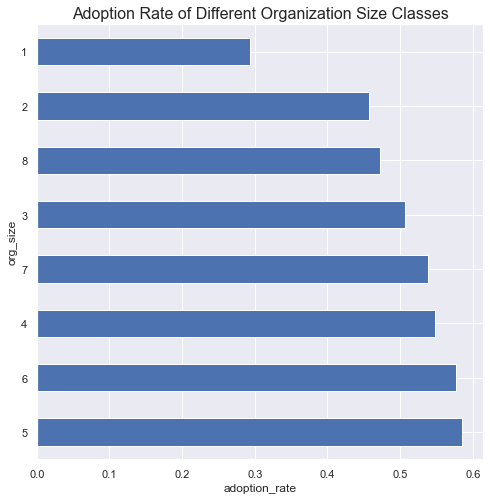

In [27]:
# Join label into features
train_resampled = join_label_into_feats(X_train_resampled, y_train_resampled)

# Adoption rate by organization
org_adoption_df = train_resampled.groupby('org_size')[['adopted_user', 'visited']].mean().sort_values('adopted_user', ascending=False)
org_adoption_df['adopted_user'].plot(kind='barh', figsize=(8, 8))
plt.title('Adoption Rate of Different Organization Size Classes', fontsize=16)
plt.xlabel('adoption_rate')

org_adoption_df

### Encode categorical variables

In [28]:
# Create an organization-to-adoption-rate mapping
org_ar = org_adoption_df['adopted_user'].sort_index().to_dict() # save for test set
print(org_ar)

# Encode `org_id` with their adoption rate
X_train_resampled['org_enc'] = X_train_resampled['org_size'].map(org_ar)
X_train_resampled.head(2)

{1: 0.29390154298310067, 2: 0.4568888888888889, 3: 0.5064, 4: 0.5483452303698897, 5: 0.585219707057257, 6: 0.5772793759141882, 7: 0.5380365490862729, 8: 0.4721445472144547}


,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,visited,first_use,days_to_first_use,same_day_use,invited,email_domain,org_size,org_enc
0,11701,2012-12-03 11:33:34,ORG_INVITE,NaT,0,0,173,0,NaT,999.0,0,1,other,4,0.548345
1,6407,2013-11-17 01:20:39,ORG_INVITE,2013-11-18 01:20:39,1,1,154,1,2013-11-18 01:20:39,1.0,0,1,gmail.com,4,0.548345


In [29]:
# Encode creation_source
src_ar = train_resampled.groupby('creation_source')['adopted_user'].mean().to_dict() # save for test set
print(src_ar)

# Encode `creation_source` with their adoption rate
X_train_resampled['creation_enc'] = X_train_resampled['creation_source'].map(src_ar)
X_train_resampled.head(2)

{'GUEST_INVITE': 0.5618441971383148, 'ORG_INVITE': 0.48620876149269876, 'PERSONAL_PROJECTS': 0.3534330985915493, 'SIGNUP': 0.5308207115181401, 'SIGNUP_GOOGLE_AUTH': 0.562838836865451}


,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,visited,first_use,days_to_first_use,same_day_use,invited,email_domain,org_size,org_enc,creation_enc
0,11701,2012-12-03 11:33:34,ORG_INVITE,NaT,0,0,173,0,NaT,999.0,0,1,other,4,0.548345,0.486209
1,6407,2013-11-17 01:20:39,ORG_INVITE,2013-11-18 01:20:39,1,1,154,1,2013-11-18 01:20:39,1.0,0,1,gmail.com,4,0.548345,0.486209


In [30]:
# Encode email_domain
dom_ar = train_resampled.groupby('email_domain')['adopted_user'].mean().to_dict() # save for test set
X_train_resampled['email_enc'] = X_train_resampled['email_domain'].map(dom_ar)
X_train_resampled.head(2)

,user_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,visited,first_use,days_to_first_use,same_day_use,invited,email_domain,org_size,org_enc,creation_enc,email_enc
0,11701,2012-12-03 11:33:34,ORG_INVITE,NaT,0,0,173,0,NaT,999.0,0,1,other,4,0.548345,0.486209,0.490603
1,6407,2013-11-17 01:20:39,ORG_INVITE,2013-11-18 01:20:39,1,1,154,1,2013-11-18 01:20:39,1.0,0,1,gmail.com,4,0.548345,0.486209,0.534219


### Select features

In [31]:
# Select features for train set
selected_cols = ['creation_enc', 'email_enc', 'org_enc', 'invited', 'same_day_use', 
                 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']
X_train = X_train_resampled[selected_cols].copy()
y_train = y_train_resampled.copy()

X_train.shape, y_train.shape

((15832, 7), (15832,))

### Feature pipeline

In [ ]:
# Features:
# same_day_use
    # first_use (encode user_id w/ `first_use`) 
    # days_to_first_use (diff first_use and creation_time in days, fill na w/ 999) 
    # same_day_use (binary encode days_to_first_use)
# invited (binary encode invited_by_user_id)
# email_enc
    # email_domain (extract domain from email, rare-category encode email_domain w/ `common_domains`) 
    # email_enc (mean-target encode email_domain w/ `dom_ar`)
# org_enc
    # org_size (bin org_id value counts w/ `org_cats`, combine bins 0 and 1)
    # org_enc (mean-target encode org_size w/ `org_ar`)
# creation_enc (mean-target encode creation_source w/ `src_ar`)

In [ ]:
def feature_pipeline(data, first_use_mapping, domain_list, domain_encoding, org_encoding, source_encoding):
    
    pass

### Modeling 1

In [29]:
# Logistic regression
lr = LogisticRegression(max_iter=1e4, random_state=0)
lr.fit(X_train, y_train)
lr_pred_train = lr.predict(X_train)
lr_pred_test = lr.predict(X_test)

print('Train')
print('Accuracy:', lr.score(X_train, y_train))
print('ROC AUC:', roc_auc_score(y_train, lr_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train, lr_pred_train))

print('\nTest')
print('Accuracy:', lr.score(X_test, y_test))
print('ROC AUC:', roc_auc_score(y_test, lr_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, lr_pred_test))

Train
Accuracy: 0.8796
ROC AUC: 0.5
Confusion matrix:
 [[8796    0]
 [1204    0]]

Test
Accuracy: 0.8795
ROC AUC: 0.5
Confusion matrix:
 [[1759    0]
 [ 241    0]]


In [30]:
# Decision tree grid search
dt = DecisionTreeClassifier(random_state=0)
params = {'max_depth': range(2, 22, 2), 'min_samples_split': range(2, 22, 2), 'min_samples_leaf': range(2, 22, 2)}
gs = GridSearchCV(dt, params, scoring='roc_auc', cv=5, n_jobs=10)
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)
gs.best_estimator_

0.6575354635252691
{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 14}


DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=14,
                       random_state=0)

In [31]:
# Decision tree
dt = gs.best_estimator_
dt.fit(X_train, y_train)
dt_pred_train = dt.predict(X_train)
dt_pred_test = dt.predict(X_test)

print('Train')
print('Score:', dt.score(X_train, y_train))
print('ROC AUC:', roc_auc_score(y_train, dt_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train, dt_pred_train))

print('\nTest')
print('Score:', dt.score(X_test, y_test))
print('ROC AUC:', roc_auc_score(y_test, dt_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, dt_pred_test))

Train
Score: 0.8799
ROC AUC: 0.5030380390361672
Confusion matrix:
 [[8791    5]
 [1196    8]]

Test
Score: 0.8795
ROC AUC: 0.5017904363805349
Confusion matrix:
 [[1758    1]
 [ 240    1]]


In [32]:
# Feature coefficients
pd.DataFrame(np.array([X_train.columns.values, lr.coef_[0], dt.feature_importances_]).T, 
             columns=['feature', 'lr_coef', 'dt_coef'])

,feature,lr_coef,dt_coef
0,creation_encoding,4.205788,0.151031
1,domain_encoding,2.176427,0.077235
2,org_encoding,6.957311,0.726139
3,invited,0.088436,0.026211
4,mailing_list,0.073873,0.007224
5,marketing_drip,-0.072596,0.01216


### Modeling 2 (with resampled data)

In [33]:
# Split data by label
train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
train0 = train[train['adopted_user'] == 0]
train1 = train[train['adopted_user'] == 1]
train.shape, train0.shape, train1.shape

((10000, 7), (8796, 7), (1204, 7))

In [34]:
# Upsample positive labels
train1_resampled = train1.sample(train0.shape[0], replace=True)

# Combine training data
train_resampled = pd.concat([train0, train1_resampled])
train_resampled['adopted_user'].value_counts()

0    8796
1    8796
Name: adopted_user, dtype: int64

In [35]:
# Split features and label
X_train_resampled = train_resampled.drop('adopted_user', axis=1).copy()
y_train_resampled = train_resampled['adopted_user'].copy()
X_train_resampled.shape, y_train_resampled.shape

((17592, 6), (17592,))

In [36]:
# Logistic regression
lr_resampled = LogisticRegression(max_iter=1e4, random_state=0)
lr_resampled.fit(X_train_resampled, y_train_resampled)
lr_resampled_pred_train = lr_resampled.predict(X_train_resampled)
lr_resampled_pred_test = lr_resampled.predict(X_test)

print('Train')
print('Accuracy:', lr_resampled.score(X_train_resampled, y_train_resampled))
print('ROC AUC:', roc_auc_score(y_train_resampled, lr_resampled_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train_resampled, lr_resampled_pred_train))

print('\nTest')
print('Accuracy:', lr_resampled.score(X_test, y_test))
print('ROC AUC:', roc_auc_score(y_test, lr_resampled_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, lr_resampled_pred_test))

Train
Accuracy: 0.6311959981809914
ROC AUC: 0.6311959981809914
Confusion matrix:
 [[5810 2986]
 [3502 5294]]

Test
Accuracy: 0.648
ROC AUC: 0.6297948428827206
Confusion matrix:
 [[1150  609]
 [  95  146]]


In [37]:
# Decision tree grid search
dt_resampled = DecisionTreeClassifier(random_state=0)
params_resampled = {'max_depth': range(2, 22, 2), 'min_samples_split': range(2, 22, 2), 'min_samples_leaf': range(2, 22, 2)}
gs_resampled = GridSearchCV(dt_resampled, params_resampled, scoring='roc_auc', cv=5, n_jobs=10)
gs_resampled.fit(X_train_resampled, y_train_resampled)

print(gs_resampled.best_score_)
print(gs_resampled.best_params_)
gs_resampled.best_estimator_

0.866930432746942
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}


DecisionTreeClassifier(max_depth=20, min_samples_leaf=2, random_state=0)

In [38]:
# Decision tree
dt_resampled = gs_resampled.best_estimator_
dt_resampled.fit(X_train_resampled, y_train_resampled)
dt_resampled_pred_train = dt_resampled.predict(X_train_resampled)
dt_resampled_pred_test = dt_resampled.predict(X_test)

print('Train')
print('Score:', dt_resampled.score(X_train_resampled, y_train_resampled))
print('ROC AUC:', roc_auc_score(y_train_resampled, dt_resampled_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train_resampled, dt_resampled_pred_train))

print('\nTest')
print('Score:', dt_resampled.score(X_test, y_test))
print('ROC AUC:', roc_auc_score(y_test, dt_resampled_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, dt_resampled_pred_test))

Train
Score: 0.8638585720782174
ROC AUC: 0.8638585720782175
Confusion matrix:
 [[6849 1947]
 [ 448 8348]]

Test
Score: 0.6645
ROC AUC: 0.5442820444471703
Confusion matrix:
 [[1236  523]
 [ 148   93]]


In [39]:
# Feature coefficients
pd.DataFrame(np.array([X_train_resampled.columns.values, lr_resampled.coef_[0], dt_resampled.feature_importances_]).T, 
             columns=['feature', 'lr_coef', 'dt_coef'])

,feature,lr_coef,dt_coef
0,creation_encoding,6.718275,0.08747
1,domain_encoding,4.738927,0.185196
2,org_encoding,8.479834,0.570833
3,invited,0.039539,0.025815
4,mailing_list,0.067371,0.070274
5,marketing_drip,-0.022876,0.060412


### Modeling 3 (with a binary feature subset)

In [40]:
# Filter for binary features
X_train_bin = X_train_resampled[['invited', 'mailing_list', 'marketing_drip']].copy()
X_test_bin = X_test[['invited', 'mailing_list', 'marketing_drip']].copy()
X_train_bin.shape, X_test_bin.shape

((17592, 3), (2000, 3))

In [41]:
# Logistic regression
lr_bin = LogisticRegression(max_iter=1e4, random_state=0)
lr_bin.fit(X_train_bin, y_train_resampled)
lr_bin_pred_train = lr_bin.predict(X_train_bin)
lr_bin_pred_test = lr_bin.predict(X_test_bin)

print('Train')
print('Accuracy:', lr_bin.score(X_train_bin, y_train_resampled))
print('ROC AUC:', roc_auc_score(y_train_resampled, lr_bin_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train_resampled, lr_bin_pred_train))

print('\nTest')
print('Accuracy:', lr_bin.score(X_test_bin, y_test))
print('ROC AUC:', roc_auc_score(y_test, lr_bin_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, lr_bin_pred_test))

Train
Accuracy: 0.5158594815825375
ROC AUC: 0.5158594815825375
Confusion matrix:
 [[4104 4692]
 [3825 4971]]

Test
Accuracy: 0.497
ROC AUC: 0.5278366857819536
Confusion matrix:
 [[857 902]
 [104 137]]


In [42]:
# Decision tree grid search
dt_bin = DecisionTreeClassifier(random_state=0)
params_bin = {'max_depth': range(2, 22, 2), 'min_samples_split': range(2, 22, 2), 'min_samples_leaf': range(2, 22, 2)}
gs_bin = GridSearchCV(dt_bin, params_bin, scoring='roc_auc', cv=5, n_jobs=10)
gs_bin.fit(X_train_bin, y_train_resampled)

print(gs_bin.best_score_)
print(gs_bin.best_params_)
gs_bin.best_estimator_

0.5222998852302774
{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}


DecisionTreeClassifier(max_depth=4, min_samples_leaf=2, random_state=0)

In [43]:
# Decision tree
dt_bin = gs_bin.best_estimator_
dt_bin.fit(X_train_bin, y_train_resampled)
dt_bin_pred_train = dt_bin.predict(X_train_bin)
dt_bin_pred_test = dt_bin.predict(X_test_bin)

print('Train')
print('Score:', dt_bin.score(X_train_bin, y_train_resampled))
print('ROC AUC:', roc_auc_score(y_train_resampled, dt_bin_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train_resampled, dt_bin_pred_train))

print('\nTest')
print('Score:', dt_bin.score(X_test_bin, y_test))
print('ROC AUC:', roc_auc_score(y_test, dt_bin_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, dt_bin_pred_test))

Train
Score: 0.5190995907230559
ROC AUC: 0.519099590723056
Confusion matrix:
 [[4124 4672]
 [3788 5008]]

Test
Score: 0.496
ROC AUC: 0.5218968718080577
Confusion matrix:
 [[858 901]
 [107 134]]


In [44]:
# Feature coefficients
pd.DataFrame(np.array([X_train_bin.columns.values, lr_bin.coef_[0], dt_bin.feature_importances_]).T, 
             columns=['feature', 'lr_coef', 'dt_coef'])

,feature,lr_coef,dt_coef
0,invited,0.1265,0.514067
1,mailing_list,0.081214,0.285027
2,marketing_drip,-0.038137,0.200905


### Modeling 4 (with encoded feature subset)

In [45]:
# Filter for encoded features
X_train_enc = X_train_resampled[['creation_encoding', 'domain_encoding', 'org_encoding']].copy()
X_test_enc = X_test[['creation_encoding', 'domain_encoding', 'org_encoding']].copy()
X_train_enc.shape, X_test_enc.shape

((17592, 3), (2000, 3))

In [46]:
# Logistic regression
lr_enc = LogisticRegression(max_iter=1e4, random_state=0)
lr_enc.fit(X_train_enc, y_train_resampled)
lr_enc_pred_train = lr_enc.predict(X_train_enc)
lr_enc_pred_test = lr_enc.predict(X_test_enc)

print('Train')
print('Accuracy:', lr_enc.score(X_train_enc, y_train_resampled))
print('ROC AUC:', roc_auc_score(y_train_resampled, lr_enc_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train_resampled, lr_enc_pred_train))

print('\nTest')
print('Accuracy:', lr_enc.score(X_test_enc, y_test))
print('ROC AUC:', roc_auc_score(y_test, lr_enc_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, lr_enc_pred_test))

Train
Accuracy: 0.6289222373806276
ROC AUC: 0.6289222373806276
Confusion matrix:
 [[5829 2967]
 [3561 5235]]

Test
Accuracy: 0.6515
ROC AUC: 0.6317846097957392
Confusion matrix:
 [[1157  602]
 [  95  146]]


In [47]:
# Decision tree grid search
dt_enc = DecisionTreeClassifier(random_state=0)
params_enc = {'max_depth': range(2, 22, 2), 'min_samples_split': range(2, 22, 2), 'min_samples_leaf': range(2, 22, 2)}
gs_enc = GridSearchCV(dt_enc, params_enc, scoring='roc_auc', cv=5, n_jobs=10)
gs_enc.fit(X_train_enc, y_train_resampled)

print(gs_enc.best_score_)
print(gs_enc.best_params_)
gs_enc.best_estimator_

0.828709171053317
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}


DecisionTreeClassifier(max_depth=20, min_samples_leaf=2, random_state=0)

In [48]:
# Decision tree
dt_enc = gs_enc.best_estimator_
dt_enc.fit(X_train_enc, y_train_resampled)
dt_enc_pred_train = dt_enc.predict(X_train_enc)
dt_enc_pred_test = dt_enc.predict(X_test_enc)

print('Train')
print('Score:', dt_enc.score(X_train_enc, y_train_resampled))
print('ROC AUC:', roc_auc_score(y_train_resampled, dt_enc_pred_train))
print('Confusion matrix:\n', confusion_matrix(y_train_resampled, dt_enc_pred_train))

print('\nTest')
print('Score:', dt_enc.score(X_test_enc, y_test))
print('ROC AUC:', roc_auc_score(y_test, dt_enc_pred_test))
print('Confusion matrix:\n', confusion_matrix(y_test, dt_enc_pred_test))

Train
Score: 0.8120736698499318
ROC AUC: 0.8120736698499318
Confusion matrix:
 [[6325 2471]
 [ 835 7961]]

Test
Score: 0.6345
ROC AUC: 0.5415503905227178
Confusion matrix:
 [[1168  591]
 [ 140  101]]


In [49]:
# Feature coefficients
pd.DataFrame(np.array([X_train_enc.columns.values, lr_enc.coef_[0], dt_enc.feature_importances_]).T, 
             columns=['feature', 'lr_coef', 'dt_coef'])

,feature,lr_coef,dt_coef
0,creation_encoding,6.862225,0.121138
1,domain_encoding,4.668249,0.23293
2,org_encoding,8.485706,0.645932
